In [32]:
from __future__ import print_function
import numpy as np
np.random.seed(42)

In [33]:
class Layer:
    
    def __init__(self):
        # Layer params
        pass
    
    def forward(self, input):
        return input
    
    def backward(self, input, grad_output):
        num_units = input.shape[1]
        d_layer_d_input = np.eye(num_units)
        return np.dot(grad_output, d_layer_d_input)
    

In [34]:
class ReLU(Layer):
    
    def __init__(self):
        pass
    
    def forward(self, input):
        relu_forward = np.maximum(0, input)
        return relu_forward
    
    def backward(self, input, grad_output):
        relu_grad = input > 0
        return grad_output*relu_grad
    

In [35]:
class Dense(Layer):
    
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale=np.sqrt(2/(input_units+output_units)), 
                                        size=(input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self, input):
        return np.dot(input, self.weights) + self.biases
    
    def backward(self, input, grad_output):
        grad_input = np.dot(grad_output, self.weights.T)
        
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [47]:
def softmax_crossentropy_with_logits(logits, reference_answers):
    logits_for_answers = logits[np.arange(len(logits)), reference_answers]
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=1))
    return xentropy

def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), reference_answers] = 1
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)
    return (- ones_for_answers + softmax) / logits.shape[0]

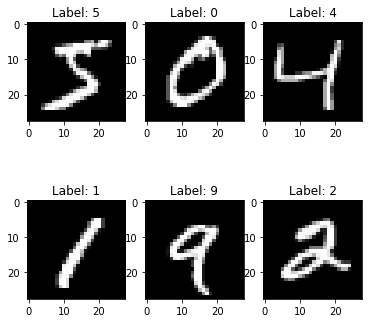

In [37]:
import keras # ONLY USING TO GET MNIST DATA!
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    
    # Normalize
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.
    
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])
        
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

# Example imgs
plt.figure(figsize=[6,6])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [59]:
# Wow this is just like keras
network = []
network.append(Dense(X_train.shape[1], 100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [60]:
def forward(network, X):
    activations = []
    input = X
    
    for l in network:
        activations.append(l.forward(input))
        input = activations[-1]
        
    assert len(activations) == len(network)
    return activations

def predict(network, X):
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)

def train(network, X, y):
    layer_activations = forward(network, X)
    layer_inputs = [X] + layer_activations
    logits = layer_activations[-1]
    
    loss = softmax_crossentropy_with_logits(logits, y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits, y)
    
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        loss_grad = layer.backward(layer_inputs[layer_index], loss_grad)
    
    return np.mean(loss)

In [61]:
from tqdm import trange

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indicies = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indicies[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


In [62]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 24
Train Accuracy: 1.0
Val Accuracy: 0.9804


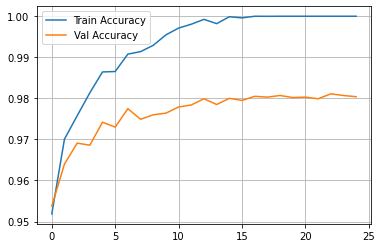

In [63]:
for epoch in range(25):
    
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train)==y_train))
    val_log.append(np.mean(predict(network, X_val)==y_val))
    
    clear_output()
    print("Epoch", epoch)
    print("Train Accuracy:", train_log[-1])
    print("Val Accuracy:", val_log[-1])
    plt.plot(train_log, label='Train Accuracy')
    plt.plot(val_log, label='Val Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [ ]:
# How in the world did this get so close my CNN for mnist!! 98.22%